<a href="https://colab.research.google.com/github/ajinkyajumde/customer-prediction/blob/main/Final_Customer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
data='/content/drive/MyDrive/Almabetter projects/Customer prediction/train_wn75k28.csv'
test_dataset=pd.read_csv(data)

In [71]:
test_dataset.head(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [72]:
test_dataset.tail(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,1,1,1,0,0,0,0,0,0
39157,39158,2021-12-31,3,9,3.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
39158,39159,2021-12-31,8,7,2.0,NaN,1,0,0,0,1,0,1,0,0,0,0,0,0
39159,39160,2021-12-31,7,12,2.0,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
39160,39161,2021-12-31,2,5,NaN,2019-08-11,1,0,0,0,0,0,1,0,0,0,0,0,0


In [73]:
test_dataset.describe()

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
count,39161.000000,39161.000000,39161.000000,18250.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000
mean,19581.000000,6.523812,6.452746,2.154137,0.400092,0.006716,0.102832,0.011465,0.151503,0.499834,0.286612,0.174434,0.011440,0.000383,0.218942,0.000562,0.051020
std,11304.951283,3.472944,2.614296,0.779815,0.509194,0.081676,0.303743,0.106463,0.359681,0.558166,0.455784,0.379689,0.106346,0.019568,0.431544,0.023696,0.220042
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9791.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19581.000000,6.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29371.000000,9.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39161.000000,16.000000,15.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [74]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [75]:
test_dataset=test_dataset.drop(columns=['signup_date','id','created_at'],axis=1)

In [76]:
test_dataset=test_dataset.dropna()

In [77]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18250 entries, 0 to 39159
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_var_1        18250 non-null  int64  
 1   campaign_var_2        18250 non-null  int64  
 2   products_purchased    18250 non-null  float64
 3   user_activity_var_1   18250 non-null  int64  
 4   user_activity_var_2   18250 non-null  int64  
 5   user_activity_var_3   18250 non-null  int64  
 6   user_activity_var_4   18250 non-null  int64  
 7   user_activity_var_5   18250 non-null  int64  
 8   user_activity_var_6   18250 non-null  int64  
 9   user_activity_var_7   18250 non-null  int64  
 10  user_activity_var_8   18250 non-null  int64  
 11  user_activity_var_9   18250 non-null  int64  
 12  user_activity_var_10  18250 non-null  int64  
 13  user_activity_var_11  18250 non-null  int64  
 14  user_activity_var_12  18250 non-null  int64  
 15  buy                

In [78]:
test_dataset['buy'].value_counts()

0    17297
1      953
Name: buy, dtype: int64

In [79]:
for i in list(test_dataset.describe()):
  print(f'The Value count for {i} is','\n')
  print(test_dataset[i].value_counts())

The Value count for campaign_var_1 is 

4     2035
5     2016
3     1935
2     1918
6     1900
7     1676
8     1523
9     1188
10     980
1      975
11     718
12     549
13     399
14     240
15     146
16      52
Name: campaign_var_1, dtype: int64
The Value count for campaign_var_2 is 

6     2688
5     2567
7     2488
8     2062
4     2050
3     1539
9     1531
2     1013
10     952
11     541
1      341
12     286
13     143
14      46
15       3
Name: campaign_var_2, dtype: int64
The Value count for products_purchased is 

2.0    8867
3.0    5024
1.0    3643
4.0     716
Name: products_purchased, dtype: int64
The Value count for user_activity_var_1 is 

0    11342
1     6765
2      143
Name: user_activity_var_1, dtype: int64
The Value count for user_activity_var_2 is 

0    18126
1      124
Name: user_activity_var_2, dtype: int64
The Value count for user_activity_var_3 is 

0    16274
1     1976
Name: user_activity_var_3, dtype: int64
The Value count for user_activity_var_4 is 

0

In [80]:
test_dataset=test_dataset.drop(columns=['user_activity_var_2','user_activity_var_3','user_activity_var_4','user_activity_var_9','user_activity_var_10','user_activity_var_12','products_purchased'],axis=1)

In [81]:
buyers=test_dataset[test_dataset['buy']==1]
non_buyers=test_dataset[test_dataset['buy']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

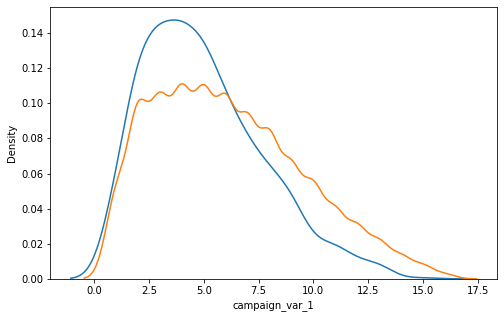

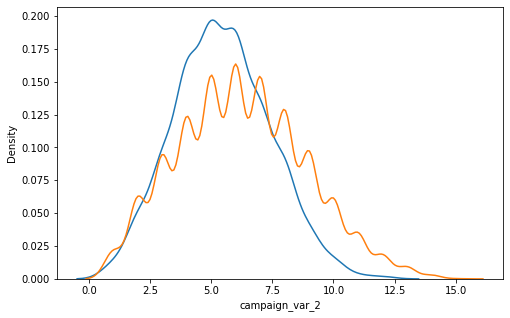

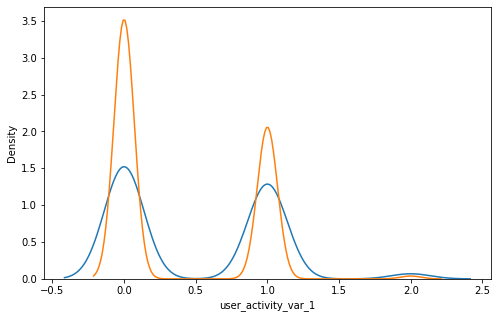

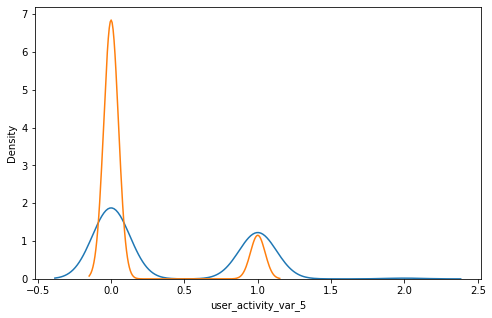

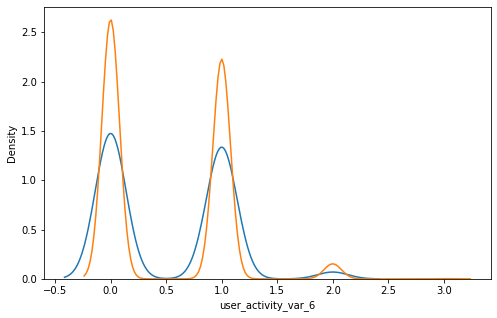

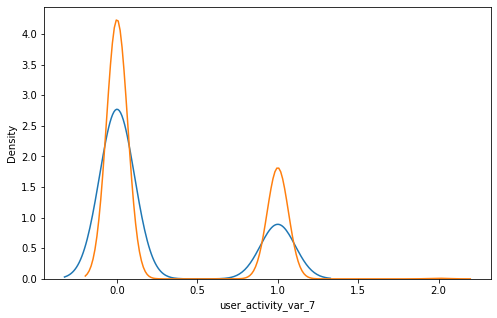

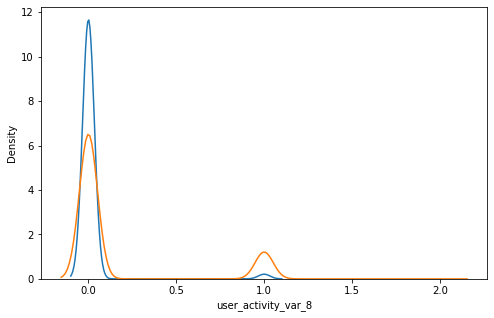

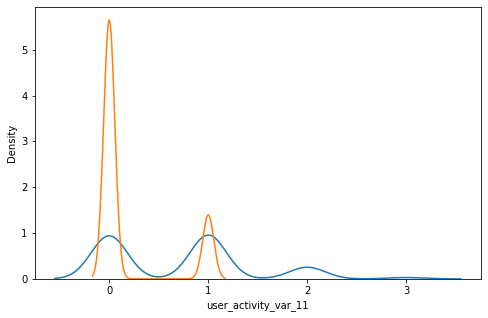

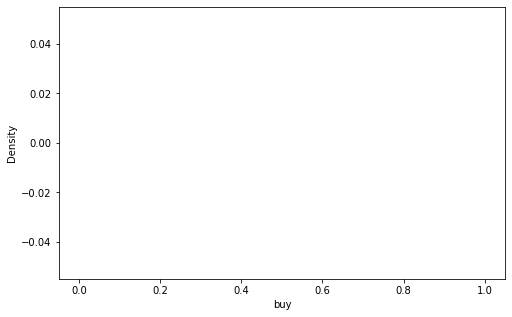

In [82]:
# Distribution plot
for i in list(test_dataset.describe()):
   plt.figure(figsize=(8,5))
   ax = sns.distplot(buyers[i],label='buy',hist=False)
   ax = sns.distplot(non_buyers[i],label='didnt buy',hist=False)
   ax.set(xlabel=i)
plt.show()

In [83]:
lst=list(test_dataset.columns)
lst

['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11',
 'buy']

In [84]:
test_dataset=pd.get_dummies(test_dataset, columns=['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11'], prefix=['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11'])

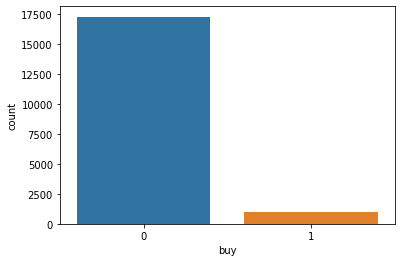

In [85]:
sns.countplot(x=test_dataset['buy'])

In [86]:
# Importing SMOTE
from imblearn.over_sampling import SMOTE

In [87]:
 # Data for all the independent variables
X = test_dataset.drop(labels='buy',axis=1)

 # Data for the dependent variable
Y = test_dataset['buy']

In [88]:
X.shape, Y.shape

((18250, 51), (18250,))

In [89]:
# Train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

In [90]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
Xtrain=X_train
cv = StratifiedKFold(n_splits=5)
X_train, Y_train = SMOTE().fit_resample(X_train, Y_train)

In [91]:
print('Before SMOTE oversampling X_train shape=',Xtrain.shape)
print('After SMOTE oversampling X_train shape=',X_train.shape)

Before SMOTE oversampling X_train shape= (14600, 51)
After SMOTE oversampling X_train shape= (27678, 51)


In [92]:
Y_train.value_counts()

0    13839
1    13839
Name: buy, dtype: int64

In [93]:
# Check the shape of train dataset
print(X_train.shape,Y_train.shape)

# Check the shape of test dataset
print(X_test.shape, Y_test.shape)

(27678, 51) (27678,)
(3650, 51) (3650,)


In [94]:
# Importing XGBoost
from xgboost import XGBClassifier

In [95]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [96]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.01,0.1,0.5,1,10,50], 
             'subsample': [0.3, 0.6, 0.9,1]}          


# specify model
xgb_model = XGBClassifier(max_depth=3, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, Y_train) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=XGBClassifier(n_estimators=200),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1, 10, 50],
                         'subsample': [0.3, 0.6, 0.9, 1]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [97]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.662122,0.015218,0.056896,0.001364,0.01,0.3,"{'learning_rate': 0.01, 'subsample': 0.3}",0.877641,0.890243,0.892601,0.886828,0.006567,13,0.897737,0.884756,0.885345,0.889279,0.005985
1,6.703297,0.304236,0.054176,0.000532,0.01,0.6,"{'learning_rate': 0.01, 'subsample': 0.6}",0.878277,0.889943,0.890175,0.886131,0.005555,14,0.898990,0.883511,0.882989,0.888497,0.007423
2,5.398706,0.317518,0.052770,0.000572,0.01,0.9,"{'learning_rate': 0.01, 'subsample': 0.9}",0.874695,0.885395,0.885918,0.882003,0.005172,16,0.894933,0.880376,0.878957,0.884755,0.007220
3,4.636450,0.028351,0.053722,0.003088,0.01,1,"{'learning_rate': 0.01, 'subsample': 1}",0.874511,0.885806,0.885953,0.882090,0.005359,15,0.895352,0.880967,0.879071,0.885130,0.007269
4,5.405624,0.008052,0.043866,0.003398,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",0.960202,0.987613,0.986693,0.978169,0.012711,9,0.988392,0.974584,0.974905,0.979294,0.006435
5,6.328056,0.014612,0.044056,0.003286,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",0.958736,0.987525,0.986969,0.977743,0.013442,10,0.987617,0.974090,0.975024,0.978910,0.006169
6,5.038009,0.004995,0.041690,0.000260,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",0.958298,0.987230,0.986328,0.977286,0.013431,11,0.986914,0.973930,0.974499,0.978448,0.005991
7,4.539298,0.007854,0.041404,0.000612,0.1,1,"{'learning_rate': 0.1, 'subsample': 1}",0.958366,0.986938,0.986120,0.977141,0.013280,12,0.987145,0.973364,0.974282,0.978264,0.006291
8,5.920141,0.308068,0.047675,0.001262,0.5,0.3,"{'learning_rate': 0.5, 'subsample': 0.3}",0.965566,0.995027,0.994685,0.985093,0.013808,4,0.996334,0.984384,0.985114,0.988611,0.005469
9,6.715587,0.415960,0.052946,0.012355,0.5,0.6,"{'learning_rate': 0.5, 'subsample': 0.6}",0.965296,0.995087,0.994652,0.985012,0.013942,5,0.996341,0.984780,0.985378,0.988833,0.005315


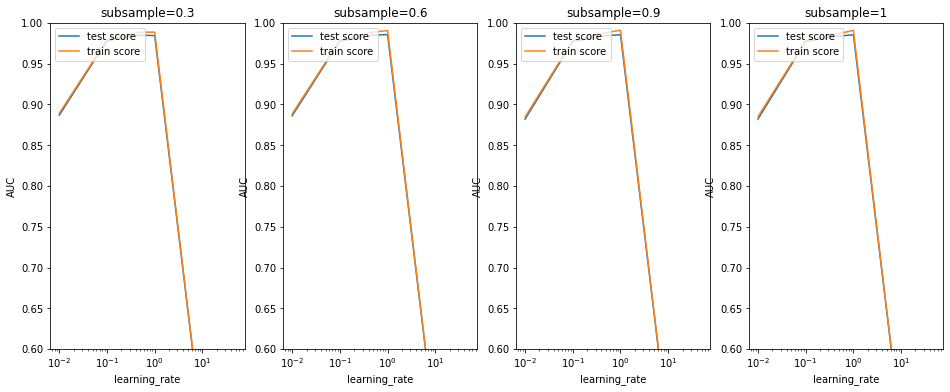

In [98]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.01,0.1,0.5,1,10], 
             'subsample': [0.3, 0.6, 0.9,1]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [99]:
model_cv.best_params_

{'learning_rate': 1, 'subsample': 0.6}

In [100]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 1,
           
          
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = params)
xgb_imb_model.fit(X_train, Y_train)

XGBClassifier(params={'learning_rate': 1, 'objective': 'binary:logistic',
                      'subsample': 0.6})

In [101]:
# Predictions on the train set
Y_train_pred = xgb_imb_model.predict(X_train)

In [102]:
# Confusion matrix
confusion = confusion_matrix(Y_train, Y_train_pred)
print(confusion)


[[13440   399]
 [ 1839 12000]]


In [103]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [104]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9191415564708433
Sensitivity:- 0.8671146759158899
Specificity:- 0.9711684370257967
F1-Score:- 0.9147038646238279


In [105]:
Y_test_pred = xgb_imb_model.predict(X_test)

In [106]:
# Confusion matrix
confusion = confusion_matrix(Y_test, Y_test_pred)
print(confusion)


[[3351  107]
 [ 134   58]]


In [107]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [108]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

Accuracy:- 0.9191415564708433
Sensitivity:- 0.3020833333333333
Specificity:- 0.9690572585309427
F1-Score:- 0.32492997198879553


## LOGISTIC REGRESSION MODEL WITH K FOLD CROSS VALIDATION

In [109]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [110]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [111]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [112]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.001,0.05,0.01, 0.1, 1, 10, 100,150,250]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.05, 0.01, 0.1, 1, 10, 100, 150, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [113]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.236930,0.014878,0.008191,0.000126,0.001,{'C': 0.001},0.971485,0.975710,0.977675,0.977015,...,0.975639,0.002180,9,0.976749,0.975715,0.975358,0.975912,0.975539,0.975855,0.000483
1,0.395546,0.013430,0.008070,0.000186,0.05,{'C': 0.05},0.976449,0.981410,0.981672,0.980347,...,0.980078,0.001884,7,0.981192,0.980018,0.980165,0.980438,0.980283,0.980419,0.000410
2,0.326288,0.017729,0.009099,0.002040,0.01,{'C': 0.01},0.974184,0.978721,0.980144,0.978555,...,0.978034,0.002015,8,0.979099,0.977965,0.978060,0.978416,0.978076,0.978323,0.000417
3,0.418920,0.042501,0.008041,0.000294,0.1,{'C': 0.1},0.977104,0.982156,0.982070,0.980897,...,0.980666,0.001851,6,0.981801,0.980618,0.980801,0.981075,0.980923,0.981044,0.000407
4,0.564042,0.015585,0.008705,0.001057,1,{'C': 1},0.978557,0.983472,0.982892,0.982006,...,0.981803,0.001710,5,0.982988,0.981920,0.982039,0.982313,0.982234,0.982299,0.000372
5,0.571067,0.020340,0.008179,0.000401,10,{'C': 10},0.979261,0.983606,0.983316,0.982398,...,0.982162,0.001542,4,0.983270,0.982292,0.982343,0.982615,0.982601,0.982624,0.000348
6,0.580280,0.022980,0.008084,0.000181,100,{'C': 100},0.979488,0.983566,0.983295,0.982459,...,0.982207,0.001448,2,0.983293,0.982379,0.982392,0.982679,0.982687,0.982686,0.000331
7,0.583931,0.020463,0.008142,0.000520,150,{'C': 150},0.979532,0.983571,0.983308,0.982473,...,0.982222,0.001435,1,0.983308,0.982373,0.982399,0.982684,0.982669,0.982686,0.000337
8,0.575336,0.025164,0.008781,0.000859,250,{'C': 250},0.979477,0.983565,0.983289,0.982439,...,0.982201,0.001451,3,0.983302,0.982374,0.982394,0.982671,0.982683,0.982685,0.000335


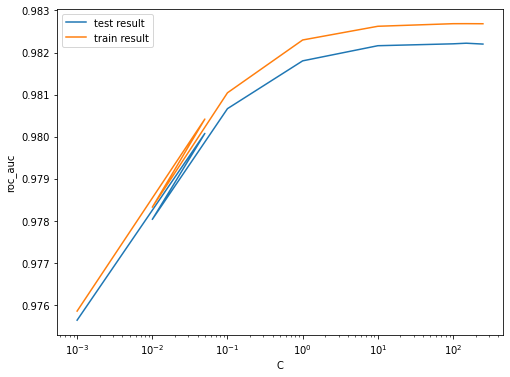

In [114]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [115]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.9822219393804451 at C = 150


In [116]:
# Instantiate the model with best C
logistic_imb = LogisticRegression(C=150)

In [117]:
# Fit the model on the train set
logistic_imb_model = logistic_imb.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [118]:
# Predictions on the train set
Y_train_pred = logistic_imb_model.predict(X_train)

In [119]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

[[13547   292]
 [ 1412 12427]]


In [120]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [121]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9384348580099718
Sensitivity:- 0.8979695064672303
Specificity:- 0.9789002095527134
F1-Score:- 0.9358385420588899


In [122]:
# Predictions on the train set
Y_test_pred = logistic_imb_model.predict(X_test)

In [123]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_test, Y_test_pred)
print(confusion)

[[3381   77]
 [ 139   53]]


In [124]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [125]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_test, Y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

Accuracy:- 0.9408219178082192
Sensitivity:- 0.2760416666666667
Specificity:- 0.9777327935222672
F1-Score:- 0.32919254658385094


## **KNN MODEL**

In [126]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,20)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, Y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test) 

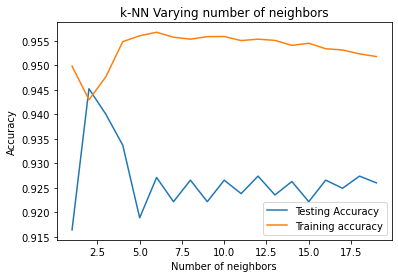

In [127]:
# Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [128]:
# Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=2)

In [129]:
# Fit the model
kn_model=knn.fit(X_train,Y_train)

In [130]:
# Predictions on the train set
Y_train_pred = kn_model.predict(X_train)

In [131]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

[[13813    26]
 [ 1553 12286]]


In [132]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [133]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9429510802803671
Sensitivity:- 0.8877809090252186
Specificity:- 0.9981212515355156
F1-Score:- 0.9396198998126266


In [134]:
# Predictions on the train set
Y_test_pred = kn_model.predict(X_test)

In [135]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_test, Y_test_pred)
print(confusion)

[[3439   19]
 [ 181   11]]


In [136]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [137]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_test, Y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_test, Y_test_pred))

Accuracy:- 0.9452054794520548
Sensitivity:- 0.057291666666666664
Specificity:- 0.9945054945054945
F1-Score:- 0.09909909909909909
